# Analisis Opini Publik Mengenai Calon Presiden Amerika Serikat

### A. Data Preparation
<p> Mengambil data twitter sesuai topik yang dibutuhkan menggunakan library tweepy, kemudian menyimpan hasil scraping tersebut ke dalam database. Scraping dilakukan selama 9 hari (18 November 2020 sampai 26 November 2020). </p>
<p> Di dalam Database memiliki 4 tabel, yaitu:
    <ul>
        <li> tabel lastscraping, </li>
        <li> tabel sentiment, </li>
        <li> tabel tweet dan </li>
        <li> tabel user </li>
    </ul>
</p>

In [1]:
#library
import tweepy
import csv
import sqlite3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools 
from nltk.probability import FreqDist
from wordcloud import WordCloud
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

In [2]:
#twitter connection
token_data = open("Documents/Studi Cases/Tugas Sanbercode/twittertoken.csv")
tokens = csv.reader(token_data,delimiter=',')

data_token = [row[2] for row in tokens]
consumer_key = data_token[0]
consumer_secret = data_token[1]
access_token = data_token[2]
access_token_secret = data_token[3]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [3]:
#sql connection
connect = sqlite3.connect("Documents/Studi Cases/DB Browser SQLite/analisis_publik.db")
cursor = connect.cursor()

In [4]:
class tugas:
    def __init__(self,topic='biden trump',max_tweet=200,start_date='2020-11-18',last_date='2020-11-27'):
        new_topic = topic+'-filter:retweets'
        #hasil = api.search(q=new_topic,count=max_tweet,tweet_mode='extended',lang='id',since=start_date,until=last_date)
        hasil = [status for status in tweepy.Cursor(api.search,q=new_topic,tweet_mode='extended',lang='id',since=start_date,until=last_date).items(max_tweet)]
        self.topic = topic
        self.max_tweet = max_tweet
        self.start_date = start_date
        self.last_date = last_date
        self.hasil = hasil
    
    def get_data(self):
        text = [tweet.full_text for tweet in self.hasil]
        tweetid = [tweet.id for tweet in self.hasil]
        userid = [tweet.user.id for tweet in self.hasil]
        created = [tweet.created_at for tweet in self.hasil]
        name = [tweet.user.name for tweet in self.hasil]
        screenname = [tweet.user.screen_name for tweet in self.hasil]
        location = [tweet.user.location for tweet in self.hasil]
        acc_created = [tweet.user.created_at for tweet in self.hasil]
        follower = [tweet.user.followers_count for tweet in self.hasil]
        friend = [tweet.user.friends_count for tweet in self.hasil]
        verified = [tweet.user.verified for tweet in self.hasil]
        return text,tweetid,userid,created,name,screenname,location,acc_created,follower,friend,verified
    
    def clean_data(self,data):
        #casefolding
        data1 = [item.lower() for item in data]
        data2 = [re.sub(r"\d+", "", item) for item in data1]
        data3 = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item).split()) for item in data2]
        
        #stopword (nltk)
        output = []
        for string in data3:
            stop_words = set(stopwords.words('indonesian'))
            word_tokens = word_tokenize(string) 
            data4 = ' '.join([word for word in word_tokens if not word in stop_words])

        #stemming (sastrawi)
            factory = StemmerFactory()
            stemmer = factory.create_stemmer()
            data5 = stemmer.stem(data4)
            output.append(data5)
        return output
        
    def save_sql(self,clean_tweet,mode):
        cursor = connect.cursor()
        if mode=='lastscraping':
            scrap = 1
            last_scraping = self.start_date
            query_lastscraping = '''insert into Lastscraping (last_get,status) values (?,?);'''  
            value = (last_scraping, scrap)  
            cursor.execute(query_lastscraping,value)
            print("Data Berhasil Masuk ke Tabel Lastscraping Database")
                
        elif mode=='tweet':
            #get last scraping_id from Lastscraping
            query_get_lastscraping = '''select max(scraping_id) from Lastscraping'''   
            cursor.execute(query_get_lastscraping) 
            scraping = cursor.fetchone()
            scraping = list(scraping)
            scraping = scraping[0]
            #get All tweet_id from Tweet
            query_get_tweetid = '''select tweet_id from Tweet'''   
            cursor.execute(query_get_tweetid) 
            key1 = cursor.fetchall()
            key2 = [str(item) for item in key1]
            key3 = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item).split()) for item in key2]
            key4 = [int(item) for item in key3]
            unique_tweet = key4
            data_ke = 0
            for tweet in self.hasil:
                if tweet.id not in unique_tweet:
                    unique_tweet.append(tweet.id)
                    query_tweet = '''insert into Tweet (tweet_id,user_id,date_created,tweet,cleantweet,scraping_id) values (?,?,?,?,?,?);'''  
                    value = (tweet.id,tweet.user.id,tweet.created_at,tweet.full_text,clean_tweet[data_ke],scraping)  
                    cursor.execute(query_tweet,value) 
                    data_ke +=1
            print("Data Berhasil Masuk ke Tabel Tweet Database")
            #return unique_tweet
        
        elif mode=='user':
            #get All user_id from User
            query_get_userid = '''select user_id from User'''   
            cursor.execute(query_get_userid) 
            key1 = cursor.fetchall()
            key2 = [str(item) for item in key1]
            key3 = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item).split()) for item in key2]
            key4 = [int(item) for item in key3]
            unique_user = key4
            for tweet in self.hasil:
                if tweet.user.id not in unique_user:
                    unique_user.append(tweet.user.id)
                    query_user = '''insert into User values (?,?,?,?,?,?,?,?);'''  
                    value = (tweet.user.id,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.created_at,tweet.user.followers_count,tweet.user.friends_count,tweet.user.verified)  
                    cursor.execute(query_user,value)
            print("Data Berhasil Masuk ke Tabel User Database")
            #return unique_user
            
        elif mode=='sentiment':
            #read Sentiment words from file
            pos_list = open("Documents/Studi Cases/Tugas Sanbercode/kata_positif.txt","r") 
            pos_words = pos_list.readlines() 
            neg_list = open("Documents/Studi Cases/Tugas Sanbercode/kata_negatif.txt","r") 
            neg_words = neg_list.readlines()
            #get All tweet_id, cleantweet from Tweet
            query_get_tweetid_cleantweet = '''select tweet_id, cleantweet from Tweet'''   
            cursor.execute(query_get_tweetid_cleantweet)
            data_tweet = cursor.fetchall()
            #get All tweet_id from Sentiment
            query_get_tweetid = '''select tweet_id from Sentiment'''   
            cursor.execute(query_get_tweetid) 
            key1 = cursor.fetchall()
            key2 = [str(item) for item in key1]
            key3 = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", item).split()) for item in key2]
            key4 = [int(item) for item in key3]
            unique_tweet = key4
            hasil = []
            for item in data_tweet:
                if item[0] not in unique_tweet:
                    unique_tweet.append(item[0])
                    count_p = 0 
                    count_n = 0 
                    for kata_pos in pos_words:
                        if kata_pos.strip() in item[1]:
                            count_p += 1 
                    for kata_neg in neg_words: 
                        if kata_neg.strip() in item[1]: 
                            count_n += 1
                    hasil.append(count_p - count_n)
                    sentiment = count_p - count_n
                    query_sentiment = '''insert into Sentiment (tweet_id, sentiment) values (?,?);'''  
                    value = (item[0], sentiment)
                    cursor.execute(query_sentiment,value)
            print("Data Berhasil Masuk ke Tabel Sentiment Database")
            #return unique_tweet
                
        else:
            pass
        connect.commit()
        cursor.close()
        #connect.close()
        
    def reset_scraping(self):
        cursor = connect.cursor()
        query_reset_lastscraping = '''UPDATE Lastscraping SET status=0;'''
        cursor.execute(query_reset_lastscraping)
        connect.commit()
        cursor.close()
        print("Data Tabel Lastscraping Berhasil di Reset ke Database")

In [5]:
data = tugas(start_date='2020-11-26',last_date='2020-11-27')
text,tweetid,userid,created,name,screenname,location,acc_created,follower,friend,verified = data.get_data()
print(text)
print(len(text))

['@Laudate_Dom @Mentimoen @AymanRashdanW Gw mah santuy hahaha tinggal tunggu claim Trump di Penn bener nggak. Nah kalau bukti kuat ada ditangan Rudy Giulliani dan Sydney Powell  biden bakal kena disqualification. Kl nggak yah mau apa lagi Trump kalah. Sayang nggak seperti 2016 ada Assange dan Snowden wikilieaks', 'Hallelujah \n\nhttps://t.co/I8neHODQM2', '@nanakuppa kalo electoral college yang menang trump, tar yang naik trump apa biden?', 'Shugaba Trump ya tubure a kan cewa shine ya samu nasarar lashe halastaccen zabe amma aka juya magana, aka shirya masa tuggu, aka tafka magudi, duk don kawai a raba shi da mulkin kasar Amurka\nhttps://t.co/qG7bn8KFkV', '@LudinWaheeda Hahaha lkaa ta mata da owaya che staaa trump pase zraa khafa de ku naa Joe Biden de bdishe', '@LudinWaheeda Lkaa saa Derrr Khaas topic um click ku 🤣 international affairs taa pke larey.. US election usho Trump lala sara ye ghata gutha okraa bss Joe Biden pke Kaar tek ku 🤣😂', 'https://t.co/n2TGXrCWC4\n\nTrump masih menola

In [6]:
clean_text = data.clean_data(text)
print(clean_text)

['dom gw mah santuy hahaha tinggal tunggu claim trump penn bener nggak bukti kuat tang rudy giulliani sydney powell biden kena disqualification kl nggak yah trump kalah sayang nggak assange snowden wikilieaks', 'hallelujah', 'kalo electoral college menang trump tar trump biden', 'shugaba trump ya tubure a cewa shine ya samu nasarar lashe halastaccen zabe amma aka juya magana aka shirya tuggu aka tafka magudi duk don kawai a raba shi da mulkin kasar amurka', 'hahaha lkaa ta mata da owaya che staaa trump pase zraa khafa de ku naa joe biden de bdishe', 'lkaa saa derrr khaas topic um click ku international affairs taa pke larey us election usho trump lala sara ye ghata gutha okraa bss joe biden pke kaar tek ku', 'trump tolak terima menang presiden pilih as joe biden proses transisi kuasa', 'dasar proyeksi media as joe biden menang suara elektoral donald trump', 'kalo greedy nyalahin biden menang udah megang trump menang akum eheh', 'kampung pantesan putin sampe ucap selamat biden moga trum

##### Melakukan Reset Status Scraping

In [7]:
data.reset_scraping()

Data Tabel Lastscraping Berhasil di Reset ke Database


##### Memasukan Hasil Scraping ke Tabel Lastscraping

In [8]:
data.save_sql(clean_text,'lastscraping')

Data Berhasil Masuk ke Tabel Lastscraping Database


##### Memasukan Hasil Scraping ke Tabel Tweet

In [9]:
data.save_sql(clean_text,'tweet')

Data Berhasil Masuk ke Tabel Tweet Database


##### Memasukan Hasil Scraping ke Tabel User

In [10]:
data.save_sql(clean_text,'user')

Data Berhasil Masuk ke Tabel User Database


##### Memasukan Hasil Scraping ke Tabel Sentiment

In [11]:
data.save_sql(clean_text,'sentiment')

Data Berhasil Masuk ke Tabel Sentiment Database


In [ ]:
connect.close()

### B. Sentiment Analysis - Polarity
<p> Hal ini dilakukan untuk menganalisa dan menilai suatu tweet/kalimat yang sudah dilakukan pembersihan melalui text preposessing (case folding, stopwords, dan stemming) apakah termasuk ke dalam sentimen positif atau negatif berdasarkan kata-kata di dalam tweet. </p>

In [12]:
pos_list= open("Documents/Studi Cases/Tugas Sanbercode/kata_positif.txt","r") 
pos_words = pos_list.readlines() 
neg_list= open("Documents/Studi Cases/Tugas Sanbercode/kata_negatif.txt","r") 
neg_words = neg_list.readlines()

#print(pos_words)
#print(neg_words)

In [13]:
query_get_tweetid_cleantweet = '''select tweet_id, cleantweet from Tweet'''   
cursor.execute(query_get_tweetid_cleantweet)
data_tweet = cursor.fetchall()
hasil = [] 
for item in data_tweet:
    count_p = 0 
    count_n = 0
    for kata_pos in pos_words:
        if kata_pos.strip() in item[1]:
            count_p += 1 
    for kata_neg in neg_words: 
        if kata_neg.strip() in item[1]: 
            count_n += 1 
    #print("positif: "+str(count_p)) 
    #print("negatif: "+str(count_n))
    hasil.append(count_p - count_n)
    #print("-----------------------------------------------------") 
    
print("Nilai rata-rata: "+str(np.mean(hasil)))
print("Standar deviasi: "+str(np.std(hasil)))
total = 0
for nilai in hasil:
    total += nilai
print("Hasil evaluasi sentiment: "+str(total))

Nilai rata-rata: -0.2762906309751434
Standar deviasi: 1.383165657050991
Hasil evaluasi sentiment: -289


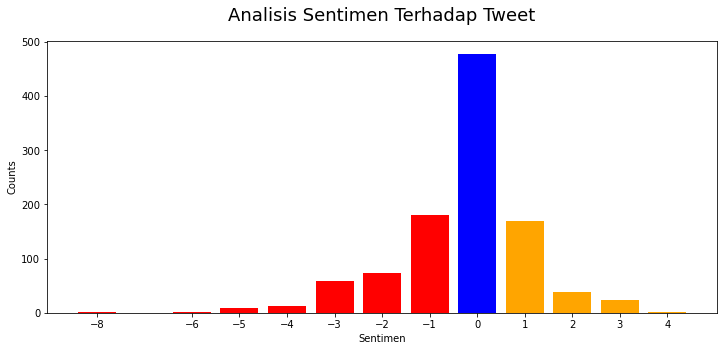

In [14]:
labels, counts = np.unique(hasil, return_counts=True) 
colors = ['red','red','red','red','red','red','red','blue','orange','orange','orange','orange']
plt.figure(figsize=(12,5))
plt.bar(labels, counts, align='center', color=colors) 
plt.title('Analisis Sentimen Terhadap Tweet', pad=20, fontsize=18)
plt.xlabel('Sentimen')
plt.ylabel('Counts')
plt.gca().set_xticks(labels)     
plt.show() 

### C. Exploratory Data pada Database Menggunakan Data Frame Pandas
<p> Melakukan eksplorasi dan pengolahan data lebih lanjut menggunakan data frame pandas untuk mendapatkan insight/pengetahuan baru dari data tersebut. </p>

In [15]:
query = "select T.tweet_id,T.date_created,U.name,U.screenname,T.tweet,T.cleantweet,S.sentiment from Tweet T INNER JOIN Sentiment S ON T.tweet_id=S.tweet_id INNER JOIN User U ON T.user_id=U.user_id GROUP BY T.tweet_id"
df_tweet = pd.read_sql_query(query, connect)
df_tweet.head()

,tweet_id,date_created,name,screenname,tweet,cleantweet,sentiment
0,1328851041866051585,2020-11-18 00:02:31,Bung Farid,bungfarid,Gw suka kebodohan model begini\n\nBiden harus ...,gw suka bodoh model biden terima kasih trump,2
1,1328857962245365760,2020-11-18 00:30:01,Warta Ekonomi,WartaEkonomi,"Sebelum Biden Dilantik, Trump Bakal Tarik Pula...",biden lantik trump tarik pulang tentara as afg...,-2
2,1328858640556584960,2020-11-18 00:32:43,Tribun Medan,tribunmedan,"Barack Obama Peringatkan Donald Trump, Minta T...",barack obama ingat donald trump terima kalah j...,-3
3,1328861040734470146,2020-11-18 00:42:15,Crona Covid,CovidCrona,USA! USA!\n\nhttps://t.co/MdnypjSfdi,usa usa,0
4,1328864553665433602,2020-11-18 00:56:13,Apni Web News,apniwebcompk,Donald Trump Ka Joe Biden Ki Jeet Ka Bilwasta ...,donald trump ka joe biden ki jeet ka bilwasta ...,0


In [16]:
hasil_sentiment = []
list_sentiment = list(df_tweet['sentiment'])
for item in list_sentiment:
    if item < 0:
        data = 1
    elif item > 0:
        data = 2
    else:
        data = 0
    hasil_sentiment.append(data)

df_tweet['label'] = hasil_sentiment
df_tweet.head()

,tweet_id,date_created,name,screenname,tweet,cleantweet,sentiment,label
0,1328851041866051585,2020-11-18 00:02:31,Bung Farid,bungfarid,Gw suka kebodohan model begini\n\nBiden harus ...,gw suka bodoh model biden terima kasih trump,2,2
1,1328857962245365760,2020-11-18 00:30:01,Warta Ekonomi,WartaEkonomi,"Sebelum Biden Dilantik, Trump Bakal Tarik Pula...",biden lantik trump tarik pulang tentara as afg...,-2,1
2,1328858640556584960,2020-11-18 00:32:43,Tribun Medan,tribunmedan,"Barack Obama Peringatkan Donald Trump, Minta T...",barack obama ingat donald trump terima kalah j...,-3,1
3,1328861040734470146,2020-11-18 00:42:15,Crona Covid,CovidCrona,USA! USA!\n\nhttps://t.co/MdnypjSfdi,usa usa,0,0
4,1328864553665433602,2020-11-18 00:56:13,Apni Web News,apniwebcompk,Donald Trump Ka Joe Biden Ki Jeet Ka Bilwasta ...,donald trump ka joe biden ki jeet ka bilwasta ...,0,0


In [17]:
topic = []
biden_word = ['joe','biden']
trump_word = ['donald','trump']
for i in range(len(df_tweet['cleantweet'])):
    count_trump = 0 
    count_biden = 0 
    for t_word in trump_word:
        if t_word in df_tweet['cleantweet'].iloc[i]:
            count_trump += 1
    for b_word in biden_word:
        if b_word in df_tweet['cleantweet'].iloc[i]: 
            count_biden += 1 
    topic.append(count_trump - count_biden)

hasil_target = []
for item in topic:
    if item < 0:
        data = 'biden'
    elif item > 0:
        data = 'trump'
    else:
        data = 'netral'
    hasil_target.append(data)

df_tweet['target_tweet'] = hasil_target
df_tweet.head()

,tweet_id,date_created,name,screenname,tweet,cleantweet,sentiment,label,target_tweet
0,1328851041866051585,2020-11-18 00:02:31,Bung Farid,bungfarid,Gw suka kebodohan model begini\n\nBiden harus ...,gw suka bodoh model biden terima kasih trump,2,2,netral
1,1328857962245365760,2020-11-18 00:30:01,Warta Ekonomi,WartaEkonomi,"Sebelum Biden Dilantik, Trump Bakal Tarik Pula...",biden lantik trump tarik pulang tentara as afg...,-2,1,netral
2,1328858640556584960,2020-11-18 00:32:43,Tribun Medan,tribunmedan,"Barack Obama Peringatkan Donald Trump, Minta T...",barack obama ingat donald trump terima kalah j...,-3,1,netral
3,1328861040734470146,2020-11-18 00:42:15,Crona Covid,CovidCrona,USA! USA!\n\nhttps://t.co/MdnypjSfdi,usa usa,0,0,netral
4,1328864553665433602,2020-11-18 00:56:13,Apni Web News,apniwebcompk,Donald Trump Ka Joe Biden Ki Jeet Ka Bilwasta ...,donald trump ka joe biden ki jeet ka bilwasta ...,0,0,netral


In [18]:
df_groupby = df_tweet[['date_created','tweet']].iloc[:]
df_groupby["order_month"] = list(df_groupby['date_created'].str[0:10])
df_groupby = df_groupby[["order_month","tweet"]]

df_groupby.head()

,order_month,tweet
0,2020-11-18,Gw suka kebodohan model begini\n\nBiden harus ...
1,2020-11-18,"Sebelum Biden Dilantik, Trump Bakal Tarik Pula..."
2,2020-11-18,"Barack Obama Peringatkan Donald Trump, Minta T..."
3,2020-11-18,USA! USA!\n\nhttps://t.co/MdnypjSfdi
4,2020-11-18,Donald Trump Ka Joe Biden Ki Jeet Ka Bilwasta ...


In [19]:
groupby = df_groupby.groupby(['order_month']).count().reset_index()

groupby.head()

,order_month,tweet
0,2020-11-18,148
1,2020-11-19,86
2,2020-11-20,153
3,2020-11-21,86
4,2020-11-22,80


##### Perbandingan Jumlah Tweet dalam Sehari 18 Nov sampai 26 Nov

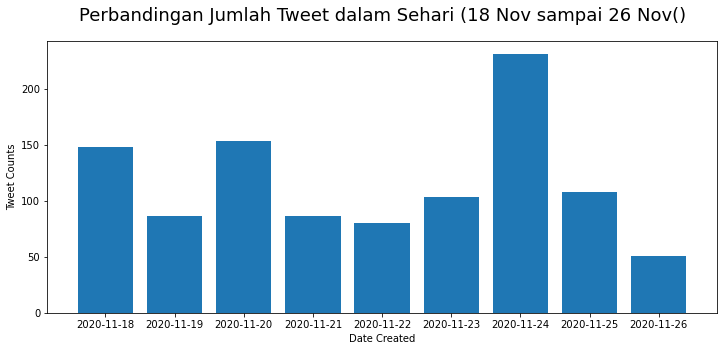

In [20]:
plt.figure(figsize=(12,5))
plt.bar(groupby['order_month'], groupby['tweet'], align='center') 
plt.title('Perbandingan Jumlah Tweet dalam Sehari (18 Nov sampai 26 Nov()', pad=20, fontsize=18)
plt.xlabel('Date Created')
plt.ylabel('Tweet Counts')
plt.show()

##### Perbandingan Data Pada Kolom Label

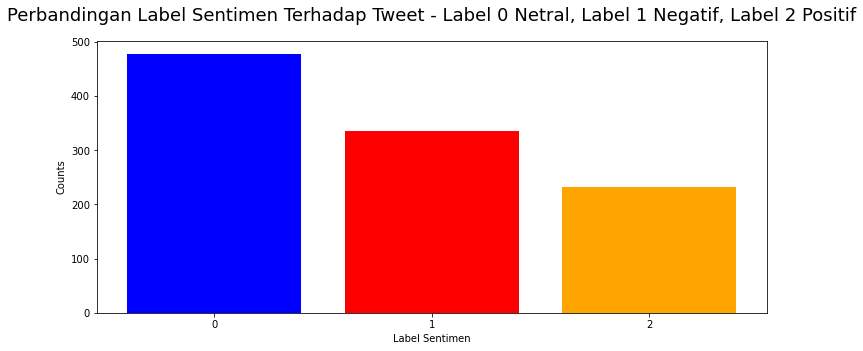

In [21]:
labels, counts = np.unique(df_tweet['label'], return_counts=True)
plt.figure(figsize=(12,5))
plt.bar(labels, counts, align='center', color=['blue','red','orange']) 
plt.title('Perbandingan Label Sentimen Terhadap Tweet - Label 0 Netral, Label 1 Negatif, Label 2 Positif', pad=20, fontsize=18)
plt.xlabel('Label Sentimen')
plt.ylabel('Counts')
plt.gca().set_xticks(labels)
plt.show() 

##### Perbandingan Data Pada Kolom Target Tweet

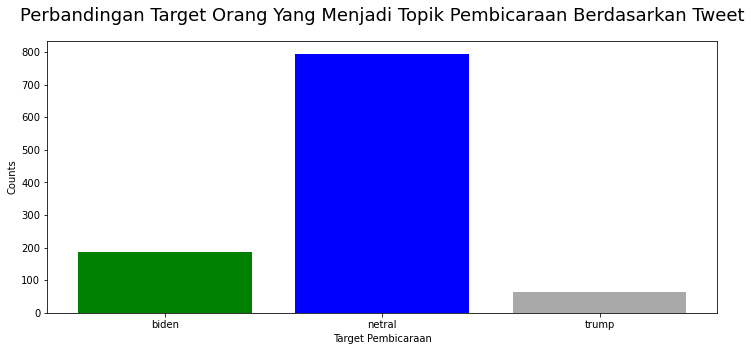

In [22]:
labels, counts = np.unique(df_tweet['target_tweet'], return_counts=True)
plt.figure(figsize=(12,5))
plt.bar(labels, counts, align='center', color=['green','blue','darkgray']) 
plt.title('Perbandingan Target Orang Yang Menjadi Topik Pembicaraan Berdasarkan Tweet', pad=20, fontsize=18)
plt.xlabel('Target Pembicaraan')
plt.ylabel('Counts')    
plt.show()

##### Top Words dan WordCloud

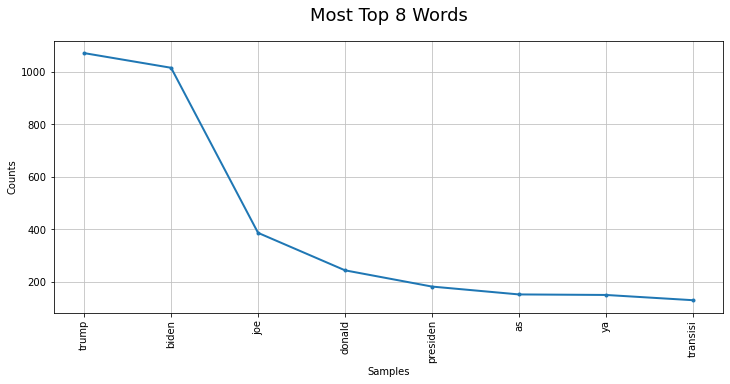

<FreqDist with 4492 samples and 15489 outcomes>


In [23]:
clean_tweet = []
for i in range(len(df_tweet['cleantweet'])):
    tweet = df_tweet['cleantweet'].iloc[i]
    clean_tweet.append(tweet)

clean_tweet_word = [word_tokenize(kalimat) for kalimat in clean_tweet]
clean_tweet_word = list(itertools.chain(*clean_tweet_word))
fqdist = FreqDist(clean_tweet_word)
plt.figure(figsize=(12,5))
plt.title('Most Top 8 Words', pad=20, fontsize=18)
fqdist.plot(8,cumulative=False,marker='.')
plt.show()
print(fqdist)
#print(fqdist.most_common(8))

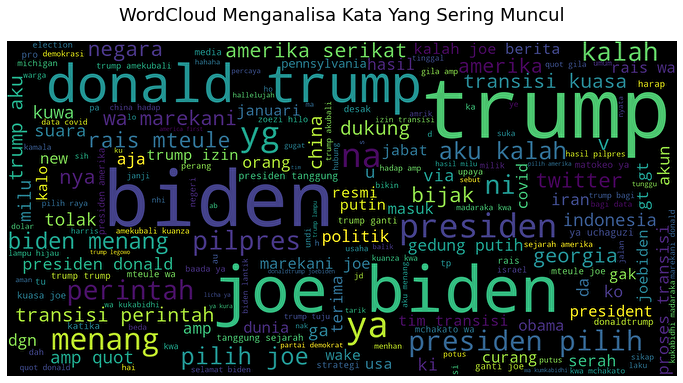

In [24]:
paragraf = ' '.join(clean_tweet_word) 
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(paragraf) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation='sinc')
plt.title('WordCloud Menganalisa Kata Yang Sering Muncul', pad=20, fontsize=18)
plt.axis("off")
plt.show()
#print(paragraf)

##### Network - X

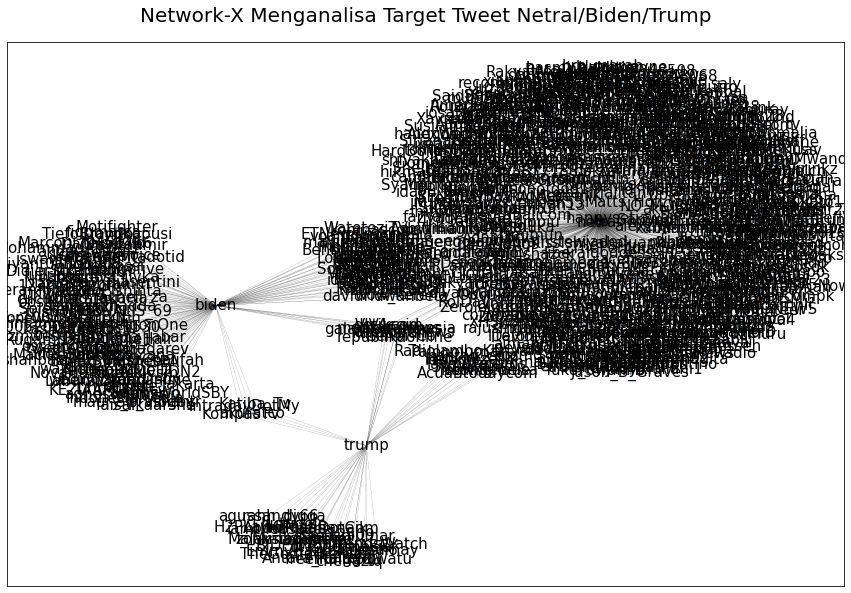

In [25]:
list_nodes = list(df_tweet['screenname']) 
list_nodes.extend(x for x in list(df_tweet['target_tweet']) if x not in list_nodes)  
#print(len(list_nodes))

G = nx.Graph()  
G.add_nodes_from(list_nodes) 
for i in range(len(df_tweet)):
    G.add_edge(df_tweet['screenname'].iloc[i],df_tweet['target_tweet'].iloc[i])
#print(G.nodes(data=True))
#print(G.edges())

plt.figure(figsize=(15,10))
nx.draw_networkx(G, node_size=1, font_size=15, width=0.1)
plt.title('Network-X Menganalisa Target Tweet Netral/Biden/Trump', pad=20, fontsize=20)
plt.show() 

### D. Data Modeling Machine Learning Classification Prediksi Label Sentimen
<p> Melakukan modeling menggunakan machine learning classification, karena dataset yang dilakukan analisis memiliki label berupa categorical value. Predictor atau Independent Variabel yang digunakan adalah clean_tweet dari data frame df_tweet. Sedangkan untuk Target atau Dependent Variabelnya adalah label dari data frame df_tweet</p>
<p> Tipe Model Classification yang digunakan adalah:
    <ul>
        <li> Naive Bayes, </li>
        <li> K-Nearest Neighbor, dan </li>
        <li> Support Vector Machines </li>
    </ul>
</p>

##### Memberi Nilai Pembobotan Untuk Setiap Data Cleantweet

In [26]:
vectorizer = TfidfVectorizer(max_features=4500)
bobot_cleantweet = vectorizer.fit_transform(df_tweet['cleantweet']).toarray()

print(bobot_cleantweet.shape)

(1046, 4467)


##### Melakukan Split Data dimana 75% Data Trainning dan 25% Data Test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(bobot_cleantweet, df_tweet['label'], test_size=0.25, random_state=1)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (784, 4467) (784,)
Test set: (262, 4467) (262,)


### Classification Modeling 
#### 1. Metode Naive Bayes

In [40]:
model_nb = GaussianNB()
model_nb.fit(X_train,y_train)
y_preds = model_nb.predict(X_test)

##### Evaluation Model Naive Bayes

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, pad=30, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.58      0.31      0.41       121
           1       0.49      0.59      0.53        82
           2       0.35      0.58      0.43        59

    accuracy                           0.46       262
   macro avg       0.47      0.49      0.46       262
weighted avg       0.50      0.46      0.45       262

Accuracy Score: 0.4580152671755725
Confusion matrix, without normalization
[[38 37 46]
 [16 48 18]
 [12 13 34]]


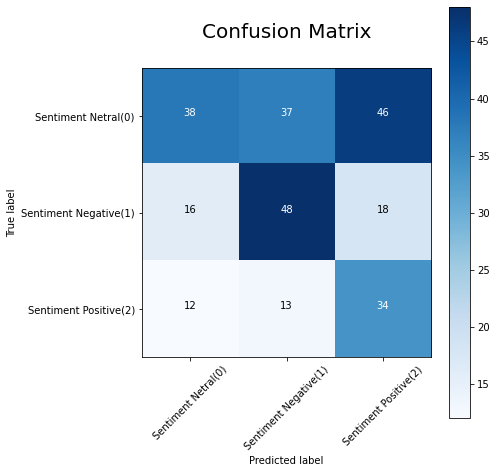

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_preds))
print('Accuracy Score:', accuracy_score(y_test, y_preds))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['Sentiment Netral(0)','Sentiment Negative(1)','Sentiment Positive(2)'],normalize= False,  title='Confusion Matrix')

##### Predict Unknown Data With Naive Bayes

In [43]:
tweet = "Masukan Tweet/Text"
tweet_bobot = vectorizer.transform([tweet]).toarray()
y_preds = model_nb.predict(tweet_bobot)

#dengan asumsi bahwa 1 merupakan label positif
if y_preds == 2:
    print('Positif')
elif y_preds == 1:
    print('Negatif')
else:
    print('Netral')

Negatif


#### 2. Metode Support Vector Machines (SVM)

In [44]:
model_svm = svm.SVC(kernel='sigmoid')
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

##### Evaluation Model Support Vector Machines

              precision    recall  f1-score   support

           0       0.62      0.93      0.74       121
           1       0.73      0.49      0.58        82
           2       0.84      0.36      0.50        59

    accuracy                           0.66       262
   macro avg       0.73      0.59      0.61       262
weighted avg       0.70      0.66      0.64       262

Accuracy Score: 0.6603053435114504
Confusion matrix, without normalization
[[112   8   1]
 [ 39  40   3]
 [ 31   7  21]]


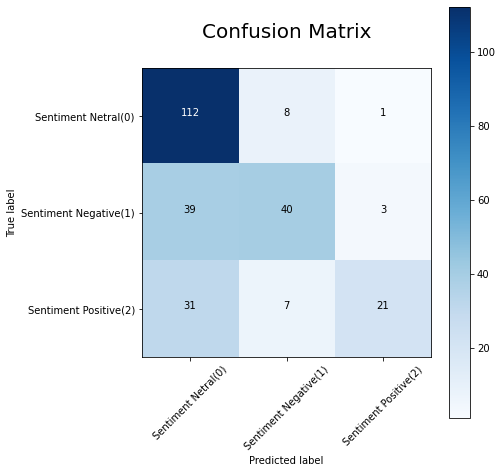

In [45]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['Sentiment Netral(0)','Sentiment Negative(1)','Sentiment Positive(2)'],normalize= False,  title='Confusion Matrix')

##### Predict Unknown Data With Support Vector Machines

In [46]:
tweet = "Masukan Tweet/Text"
tweet_bobot = vectorizer.transform([tweet]).toarray()
y_pred = model_svm.predict(tweet_bobot)

#dengan asumsi bahwa 1 merupakan label positif
if y_preds == 2:
    print('Positif')
elif y_preds == 1:
    print('Negatif')
else:
    print('Netral')

Negatif


#### 3. Metode K-Nearest Neighbor (KNN)

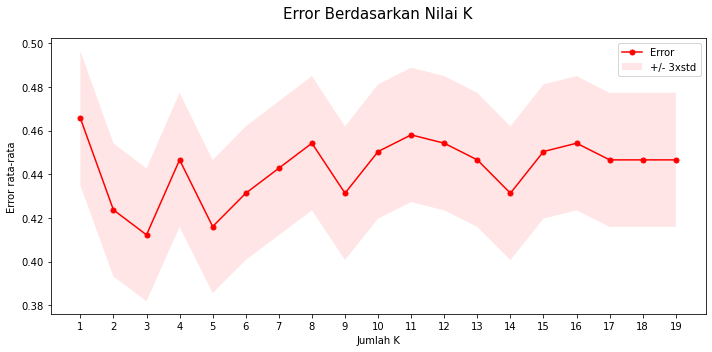

In [35]:
Ke = 20
acc_std = np.zeros((Ke-1))
labelx = []
error = []
for i in range(1, Ke):
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(X_train, y_train)
    y_hat = model_knn.predict(X_test)
    error.append(np.mean(y_hat != y_test))
    acc_std[i-1] = np.std(y_hat != y_test)/np.sqrt(y_hat.shape[0])
    labelx.append(i)

plt.figure(figsize=(10,5))  
plt.plot(range(1, Ke), error, color='red', marker='o', markersize=5)
plt.fill_between(range(1, Ke), error - 1 * acc_std, error + 1 * acc_std, facecolor='red', alpha=0.10)
plt.legend(('Error', '+/- 3xstd'))
plt.title('Error Berdasarkan Nilai K', pad=20, fontsize=15)  
plt.xlabel('Jumlah K')  
plt.ylabel('Error rata-rata')
plt.gca().set_xticks(labelx)
plt.tight_layout()
plt.show()

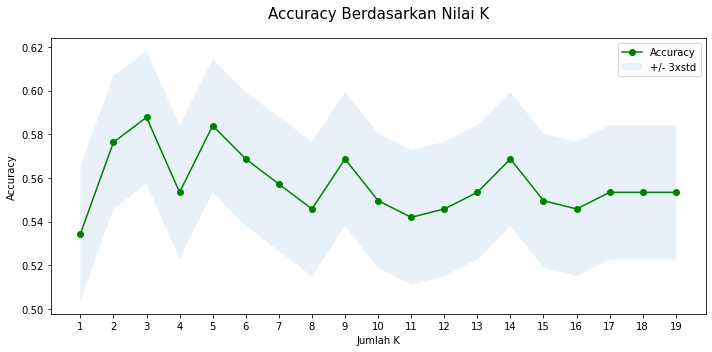

In [36]:
Ka = 20
mean_acc = np.zeros((Ka-1))
std_acc = np.zeros((Ka-1))
labelx = []
ConfustionMx = [];
for n in range(1,Ka):  
    model_knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_hat = model_knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_hat)
    std_acc[n-1] = np.std(y_hat==y_test)/np.sqrt(y_hat.shape[0])
    labelx.append(n)

plt.figure(figsize=(10,5))
plt.plot(range(1,Ka),mean_acc,'green',marker='o')
plt.fill_between(range(1,Ka),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy', '+/- 3xstd'))
plt.title('Accuracy Berdasarkan Nilai K', pad=20, fontsize=15)  
plt.xlabel('Jumlah K')
plt.ylabel('Accuracy')
plt.gca().set_xticks(labelx)
plt.tight_layout()
plt.show()

In [47]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)
y_hat = model_knn.predict(X_test)

##### Evaluation Model K-Nearest Neighbor

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       121
           1       0.56      0.54      0.55        82
           2       0.57      0.39      0.46        59

    accuracy                           0.59       262
   macro avg       0.58      0.55      0.56       262
weighted avg       0.58      0.59      0.58       262

Accuracy Score: 0.5877862595419847
Confusion matrix, without normalization
[[87 25  9]
 [30 44  8]
 [26 10 23]]


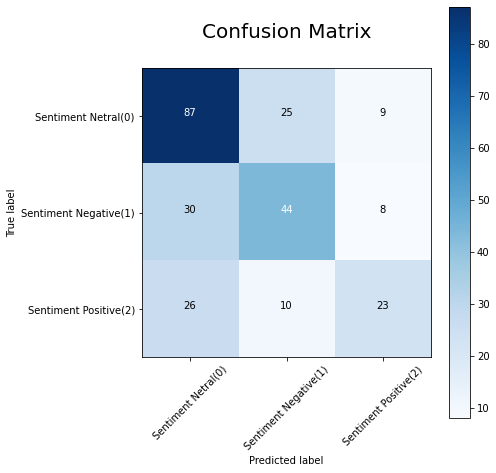

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_hat))
print('Accuracy Score:', accuracy_score(y_test, y_hat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['Sentiment Netral(0)','Sentiment Negative(1)','Sentiment Positive(2)'],normalize= False,title='Confusion Matrix')

##### Predict Unknown Data With K-Nearest Neighbor

In [49]:
tweet = "Masukan Tweet/Text"
tweet_bobot = vectorizer.transform([tweet]).toarray()
y_hat = model_knn.predict(tweet_bobot)

#dengan asumsi bahwa 1 merupakan label positif
if y_preds == 2:
    print('Positif')
elif y_preds == 1:
    print('Negatif')
else:
    print('Netral')

Negatif
